## Baseline model with all clues

### Data Import

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from sklearn.metrics import classification_report

In [2]:
clues = pd.read_csv('clues.csv', index_col=0)
clues.shape

(10000, 3)

In [3]:
labels = pd.read_csv('selected_labels.csv')
labels = labels.drop(columns=['Ball', 'Gate', 'referee Image'])

In [4]:
LABELS = [
    'Start/Restar the game',
    'The joy of the players',
    'yellow card',
    'Red Card',
    'Stadium View',
    'Penalty Image',
    'Free Kick',
    'Generic Moment'
]

In [5]:
# visualize the mapping from label names to indices
label_to_index = {label: idx for idx, label in enumerate(LABELS)}
label_to_index

{'Start/Restar the game': 0,
 'The joy of the players': 1,
 'yellow card': 2,
 'Red Card': 3,
 'Stadium View': 4,
 'Penalty Image': 5,
 'Free Kick': 6,
 'Generic Moment': 7}

In [6]:
labels['label'] = labels[LABELS].idxmax(axis=1).map({label: idx for idx, label in enumerate(LABELS)})
labels['label'] = labels['label'].astype(int)

In [7]:
labels = labels.drop(columns=LABELS)

In [8]:
# ==== Transforms ====
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

In [12]:
# ==== Config ====
batch_size = 32
learning_rate = 1e-3
num_epochs = 10
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [13]:
class FootballDataset(Dataset):
    def __init__(self, df, clues_df, image_folder, transform=None):

        self.df = df
        self.clues_df = clues_df
        self.image_folder = image_folder
        self.transform = transform
        

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        main_row = self.df.iloc[idx]
        
        # corresponding row from clues DataFrame
        clues_row = self.clues_df.iloc[idx]
        
        img_path = os.path.join(self.image_folder, str(main_row['Image Number']) + '.jpg')
        image = Image.open(img_path).convert('RGB')
        
        label = main_row['label']
        
        binary_features = torch.tensor([
            float(clues_row['Ball']), 
            float(clues_row['Gate']), 
            float(clues_row['Referee'])
        ], dtype=torch.float32)
        
        if self.transform:
            image = self.transform(image)
            
        return image, label, binary_features

In [14]:
# ==== Load Data ====
image_path = 'data/selected_images'

# First, split your original labels DataFrame into train/val/test splits (these are DataFrames)
train_val_df, test_df = train_test_split(labels, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.1, random_state=42)

train_dataset = FootballDataset(
    df=train_df,  # use train_df instead of train_dataset
    clues_df=clues,
    image_folder='data/selected_images',
    transform=transform
)

val_dataset = FootballDataset(
    df=val_df,  # use val_df instead of val_dataset
    clues_df=clues,
    image_folder='data/selected_images',
    transform=transform
)

test_dataset = FootballDataset(
    df=test_df,  # use test_df instead of test_dataset
    clues_df=clues,
    image_folder='data/selected_images',
    transform=transform
)

# Then create your data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

After carrying out all the usual preprocessing, we modify the standard ResNet18 architecture to incorporate additional binary features alongside the visual features extracted from football match images.

In particular, we replace the original fully connected layer with an identity function to maintain ResNet18 as a feature extractor, then we create a new classification head that concatenates the 512-dimensional ResNet features with 3 additional binary features (representing object-level elements like ball presence, referee presence, and goalkeeper presence).\
The modified model loads pre-trained weights from your baseline ResNet18 while adapting the final layer to handle the expanded feature space (515 dimensions total).\
This approach allows us to leverage both the spatial visual information learned by the CNN and explicit contextual clues about key football elements to improve match event classification performance.

In [15]:
class AllClues_ResNet(nn.Module):
    def __init__(self, num_classes=8, pretrained_path=None):
        super(AllClues_ResNet, self).__init__()
        
        # ResNet18 without pre-trained weights initially
        self.resnet = models.resnet18(pretrained=False)
        
        # Save the original FC layer's input size
        fc_input_size = self.resnet.fc.in_features  # Should be 512 for ResNet18
        
        # Replace the FC layer with identity to use as feature extractor
        self.resnet.fc = nn.Identity()
        
        # Create a new FC layer for the combined features
        # fc_input_size (512) + number of binary features (3)
        self.fc = nn.Linear(fc_input_size + 3, num_classes)
        
        # Load your pre-trained weights if provided
        if pretrained_path:
            self.load_pretrained_weights(pretrained_path)
    
    def load_pretrained_weights(self, pretrained_path):
        # Load the state dict from your trained model
        pretrained_dict = torch.load(pretrained_path)
        
        # If the state dict is from the direct model (not a training checkpoint)
        # it should be directly applicable to self.resnet except for the final FC layer
        model_dict = self.resnet.state_dict()
        
        # Filter out the FC layer weights from the pretrained model
        pretrained_dict = {k: v for k, v in pretrained_dict.items() 
                          if k in model_dict and 'fc' not in k}
        
        # Update the model weights
        model_dict.update(pretrained_dict)
        self.resnet.load_state_dict(model_dict, strict=False)
        
        # Optionally initialize the new FC layer using the weights from the original FC
        # This requires some reshaping and could be skipped
        # If your state dict has the FC weights and you want to initialize the relevant part
        if 'fc.weight' in pretrained_dict:
            with torch.no_grad():
                # Original weights
                original_fc_weight = pretrained_dict['fc.weight']  # shape: [num_classes, 512]
                original_fc_bias = pretrained_dict['fc.bias']      # shape: [num_classes]
                
                # Initialize the corresponding part of the new FC weights
                self.fc.weight.data[:, :fc_input_size] = original_fc_weight
                self.fc.bias.data = original_fc_bias
    
    def forward(self, x, binary_features):
        # Extract features from the image using ResNet
        features = self.resnet(x)  # This gives us the 512-dim feature vector
        
        # Concatenate with binary features
        combined_features = torch.cat((features, binary_features), dim=1)
        
        # Final classification
        return self.fc(combined_features)

In [16]:
# Number of classes in your dataset
num_classes = 8  # Based on your LABELS list

# Path to your pre-trained model
pretrained_path = 'resnet18_football_best.pth'

# Create the enhanced model
enhanced_model = AllClues_ResNet(num_classes=num_classes, pretrained_path=pretrained_path)

# Move to appropriate device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
enhanced_model = enhanced_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(enhanced_model.parameters(), lr=learning_rate)

/home/martinaserandrei/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/martinaserandrei/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [17]:
train_acc, val_acc, train_loss, val_loss = [], [], [], []
best_val_loss = float('inf')
# Training loop
for epoch in range(num_epochs):
    enhanced_model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels, binary_features in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        binary_features = binary_features.to(device)

        optimizer.zero_grad()
        outputs = enhanced_model(images, binary_features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total * 100
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)

    # Validation
    enhanced_model.eval()
    val_running_loss = 0.0
    val_correct, val_total = 0, 0

    with torch.no_grad():
        # Fix 1: Unpack three values, not two
        for images, labels, binary_features in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            binary_features = binary_features.to(device)
            
            # Fix 2: Pass binary_features to the model
            outputs = enhanced_model(images, binary_features)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_epoch_loss = val_running_loss / len(val_loader)
    val_epoch_acc = val_correct / val_total * 100
    val_loss.append(val_epoch_loss)
    val_acc.append(val_epoch_acc)

    print(f"[{epoch+1}/{num_epochs}] Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.2f}%, Val Loss: {val_epoch_loss:.4f}, Acc: {val_epoch_acc:.2f}%")
    
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        # Fix 3: Save enhanced_model, not model
        torch.save(enhanced_model.state_dict(), 'baseline_clues.pth')
        print("✅ Saved new best model.")

print("Training complete.")

[1/10] Train Loss: 0.4584, Acc: 84.69%, Val Loss: 0.5453, Acc: 80.88%
✅ Saved new best model.
[2/10] Train Loss: 0.3047, Acc: 89.58%, Val Loss: 0.5887, Acc: 81.75%
[3/10] Train Loss: 0.2378, Acc: 91.99%, Val Loss: 0.5546, Acc: 81.38%
[4/10] Train Loss: 0.1616, Acc: 94.58%, Val Loss: 0.6781, Acc: 81.88%
[5/10] Train Loss: 0.1226, Acc: 95.88%, Val Loss: 0.6864, Acc: 83.12%
[6/10] Train Loss: 0.0867, Acc: 96.89%, Val Loss: 0.9558, Acc: 83.00%
[7/10] Train Loss: 0.1368, Acc: 95.26%, Val Loss: 0.6109, Acc: 83.12%
[8/10] Train Loss: 0.0810, Acc: 97.31%, Val Loss: 0.6014, Acc: 84.50%
[9/10] Train Loss: 0.0442, Acc: 98.51%, Val Loss: 0.6387, Acc: 84.62%
[10/10] Train Loss: 0.0813, Acc: 97.33%, Val Loss: 0.8020, Acc: 81.12%
Training complete.


### Evaluation metrics and confusion matrix

In [18]:
# ==== Load Best Enhanced Model ====
enhanced_model = AllClues_ResNet(num_classes=len(LABELS))
enhanced_model.load_state_dict(torch.load('baseline_clues.pth'))
enhanced_model.to(device)
enhanced_model.eval()

# ==== Inference on Test Set ====
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels, binary_features in test_loader:
        images = images.to(device)
        binary_features = binary_features.to(device)
        
        outputs = enhanced_model(images, binary_features)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())


In [19]:
report = classification_report(all_labels, all_preds, 
                               target_names=LABELS, 
                               digits=3)
print(report)

                        precision    recall  f1-score   support

 Start/Restar the game      0.976     0.625     0.762        64
The joy of the players      0.770     0.782     0.776       257
           yellow card      0.967     0.757     0.849       115
              Red Card      0.800     0.308     0.444        13
          Stadium View      0.840     0.938     0.886       660
         Penalty Image      0.896     0.833     0.863        72
             Free Kick      0.886     0.738     0.805       431
        Generic Moment      0.668     0.758     0.710       388

              accuracy                          0.811      2000
             macro avg      0.850     0.717     0.762      2000
          weighted avg      0.821     0.811     0.811      2000



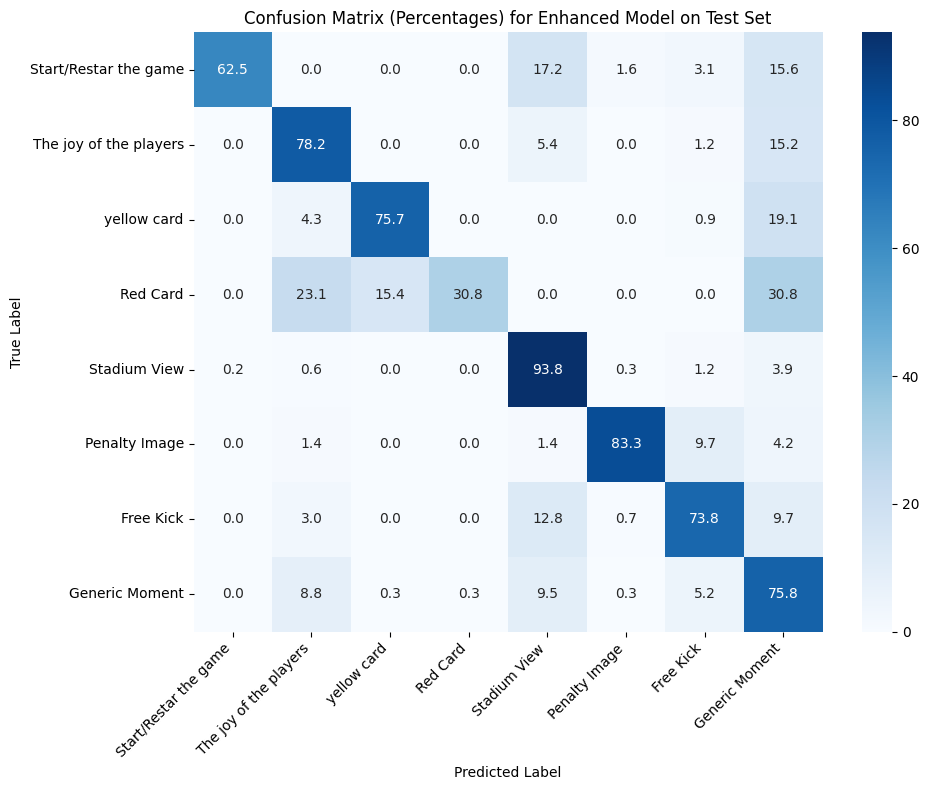

Test Accuracy: 81.15%


In [20]:

# ==== Compute Confusion Matrix ====
cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(LABELS))))
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues", xticklabels=LABELS, yticklabels=LABELS)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Percentages) for Enhanced Model on Test Set')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('enhanced_model_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# ==== Calculate overall accuracy ====
accuracy = np.sum(np.diag(cm)) / np.sum(cm) * 100
print(f"Test Accuracy: {accuracy:.2f}%")

In [21]:
# Convert to numpy arrays (if not already)
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Calculate per-class accuracy
class_correct = [0] * len(LABELS)
class_total = [0] * len(LABELS)

for i in range(len(all_labels)):
    label = all_labels[i]
    pred = all_preds[i]
    class_total[label] += 1
    if pred == label:
        class_correct[label] += 1

# Calculate class accuracies with proper handling of zero division
class_accuracies = [100 * c / t if t > 0 else 0 for c, t in zip(class_correct, class_total)]

# Calculate overall accuracy
overall_accuracy = sum(class_correct) / sum(class_total) * 100

# Print per-class accuracy as table
print(f"{'Class':<25}{'Accuracy':>10}")
print("-" * 35)
for label, acc in zip(LABELS, class_accuracies):
    print(f"{label:<25}{acc:>9.2f}")
print("-" * 35)
print(f"{'Overall':<25}{overall_accuracy:>9.2f}")

Class                      Accuracy
-----------------------------------
Start/Restar the game        62.50
The joy of the players       78.21
yellow card                  75.65
Red Card                     30.77
Stadium View                 93.79
Penalty Image                83.33
Free Kick                    73.78
Generic Moment               75.77
-----------------------------------
Overall                      81.15


This model has slightly improved from the baseline model